## Setup imports

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandAffined,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, SwinUNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, ThreadDataLoader
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import nibabel as nib

print_config()

MONAI version: 1.3.1
Numpy version: 1.24.3
Pytorch version: 2.3.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: d:\Users\hellp\anaconda3\envs\pt_env\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.18.0
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.41.1
mlflow version: 2.13.0
pynrrd version: 1.0.0
clearml version: 1.16.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory and hyper-parameters

download dataset from https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar

delete lung_096.nii from :Task06_Lung/imagesTr and Task06_Lung/labelsTr

In [2]:
root_dir = "Lung"
data_dir = "Task06_Lung"
roi = (160, 160, 160)
batch_size_train = 2
batch_size_val = 1
sw_batch = 4
num_work = 4
cacherate = 1.0
lr_rate = 1e-4
max_epochs = 20
val_interval = 4
setseed = 23

### Wandb

In [3]:
import wandb
import random

my_secret = open("Coding\wanb\keyAPI.txt")
wandb.login(key=my_secret.read())

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pinyawat-ssnr-23 (hellper). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\hellp\.netrc


True

In [4]:
#wandb to get start

#setup project
wandb.init(project = 'lung-tumor-segmentation',
           group='unet',
           )
wandb.define_metric("epoch")
wandb.define_metric ("val/dice_metric", step_metric= "epoch")
wandb.define_metric ("train/loss_epoch", step_metric= "epoch")
wandb.define_metric ("epoch", step_metric= "epoch")
wandb.define_metric ("best_dice_metric", step_metric= "epoch")
wandb.define_metric ("best_metric_epoch", step_metric= "epoch")


#setup config
config = wandb.config
config.seed = setseed
config.roi_size = roi
config.train_batch_size = batch_size_train
config.val_batch_size = batch_size_val
config.num_workers = num_work
config.cache_rate = cacherate
# config.weight_decay = 1e-5
config.max_train_epochs = max_epochs
config.validation_intervals = val_interval
config.model_type = "unet"
config.dice_loss = "sigmoid"
config.optimizer = "adamw"
config.initial_learning_rate = lr_rate
config.loss_function = "diceLoss"
config.dice_loss_target_onehot = True
config.model_params = dict(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
)
# config.dataset_dir = "./dataset/"
# config.checkpoint_dir = "./checkpoints"
# config.inference_roi_size = (128, 128, 64)
# config.max_prediction_images_visualized = 20


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

## Set MSD Spleen dataset path

In [7]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "lung_*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "lung_*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

print("train images:", len(train_images), "train labels:", len(train_labels))



train images: 62 train labels: 62


In [8]:
# train_files, val_files = data_dicts[:-13], data_dicts[-13:]

train_files, val_files, test_files = data_dicts[:50], data_dicts[50:60], data_dicts[-2:]
print('train files:', len(train_files), ' val files:', len(val_files), ' test files:', len(test_files))

train files: 50  val files: 10  test files: 2


## Set deterministic training for reproducibility

In [9]:
set_determinism(seed=setseed)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [10]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # # Transform1
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        # RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=0),
        # RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=1),
        # RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=2),
        # RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        # RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


## Check transforms in DataLoader

image shape: torch.Size([214, 204, 185]), label shape: torch.Size([214, 204, 185])


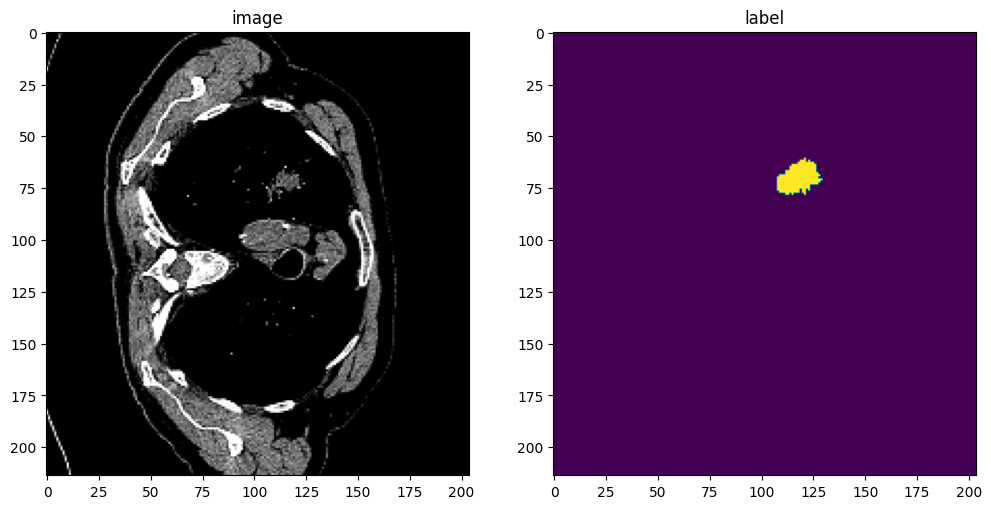

In [11]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

# plot the slice [:, :, 80]
slice_idx = 140
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, slice_idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slice_idx])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [12]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
train_loader = ThreadDataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
val_loader = ThreadDataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


## Create Model, Loss, Optimizer

In [13]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr_rate)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
# # os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device = torch.device("cuda:0")
# model = SwinUNETR(
#     img_size=(96, 96, 96),
#     in_channels=1,
#     out_channels=2,
#     feature_size=48,
# ).to(device)

# torch.backends.cudnn.benchmark = True
# loss_function = DiceLoss(to_onehot_y=True, softmax=True) #muli segmention
# # loss_function = DiceLoss(to_onehot_y=True, sigmoid=True) #binary segmention
# optimizer = torch.optim.Adam(model.parameters(), lr_rate)
# dice_metric = DiceMetric(include_background=False, reduction="mean")

In [14]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

4808917


## Execute a typical PyTorch training process

In [15]:
import time

# max_epochs = 200
# val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
# best_metrics_epochs_and_time = [[], [], []]
# epoch_times = []
# total_start = time.time()

### Execute 

In [17]:

#log gradients of the model to wandb
wandb.watch(model, log_freq=100)

for epoch in range(max_epochs):
    # epoch_start = time.time() # Logtime
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        
        # log train_loss for each step to wandb
        # wandb.log({"train/loss": loss.item()})
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    wandb.log({"epoch": epoch + 1, "train/loss_epoch": epoch_loss})
    
    # #step scheduler after each epoch (cosine decay)
    # scheduler.step()
    
    #log train_loss averaged over epoch to wandb
    # wandb.log({"train/loss_epoch": epoch_loss})
    
    # #log learning rate after each epoch to wandb
    # wandb.log({"learning_rate": scheduler.get_lr()[0]})

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = roi
                sw_batch_size = sw_batch
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            
            #log validation dice score for each validation round
            wandb.log({"epoch": epoch + 1, "val/dice_metric": metric})
            
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                
                # # log time
                # best_metrics_epochs_and_time[0].append(best_metric)
                # best_metrics_epochs_and_time[1].append(best_metric_epoch)
                # best_metrics_epochs_and_time[2].append(time.time() - total_start)
                
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            wandb.log({"best_dice_metric": best_metric, "best_metric_epoch": best_metric_epoch})

# # log time            
#         print(f"time consuming of epoch {epoch + 1} is:" f" {(time.time() - epoch_start):.4f}")
#         epoch_times.append(time.time() - epoch_start)
# total_time = time.time() - total_start
            
#log best score and epoch number to wandb
wandb.log({"best_dice_metric": best_metric, "best_metric_epoch": best_metric_epoch})

# 🐝 Close your wandb run
wandb.finish()


----------
epoch 1/20
1/25, train_loss: 0.6296
2/25, train_loss: 0.6250
3/25, train_loss: 0.6278
4/25, train_loss: 0.6268
5/25, train_loss: 0.6246
6/25, train_loss: 0.6252
7/25, train_loss: 0.6223
8/25, train_loss: 0.6270
9/25, train_loss: 0.6263
10/25, train_loss: 0.6248
11/25, train_loss: 0.6228
12/25, train_loss: 0.6260
13/25, train_loss: 0.6259
14/25, train_loss: 0.6250
15/25, train_loss: 0.6239
16/25, train_loss: 0.6223
17/25, train_loss: 0.6236
18/25, train_loss: 0.6245
19/25, train_loss: 0.6215
20/25, train_loss: 0.6208
21/25, train_loss: 0.6236
22/25, train_loss: 0.6034
23/25, train_loss: 0.6145
24/25, train_loss: 0.6107
25/25, train_loss: 0.6227
epoch 1 average loss: 0.6228
----------
epoch 2/20
1/25, train_loss: 0.6216
2/25, train_loss: 0.6153
3/25, train_loss: 0.6219
4/25, train_loss: 0.6131
5/25, train_loss: 0.6186
6/25, train_loss: 0.6173
7/25, train_loss: 0.6207
8/25, train_loss: 0.6195
9/25, train_loss: 0.6208
10/25, train_loss: 0.6072
11/25, train_loss: 0.6184
12/25, tr

best_dice_metric,▁▁▂▇██
best_metric_epoch,▁▃▅▆██
epoch,▁▁▂▂▂▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇█████
train/loss_epoch,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁
val/dice_metric,▁▁▁▂▇█
best_dice_metric,0.02167
best_metric_epoch,20
epoch,20
train/loss_epoch,0.50371
val/dice_metric,0.02167


In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 140], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 140])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 140])
        plt.show()
        if i == 2:
            break